In [1]:
# import the necessary packages
from keras import backend as K
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.datasets import mnist
from keras.utils import np_utils
from keras.optimizers import SGD, RMSprop, Adam
import numpy as np

np.random.seed(1671)  # for reproducibility

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
def load_and_format(in_path):
    out_df = pd.read_json(in_path)
    out_images = out_df.apply(lambda c_row: [np.stack([c_row['band_1'],c_row['band_2']], -1).reshape((75,75,2))],1)
    out_images = np.stack(out_images).squeeze()
    return out_df, out_images


In [3]:
base_path = 'data/iceberg'

In [4]:
train_df, train_images = load_and_format(os.path.join(base_path, 'train.json'))
print('training', train_df.shape, 'loaded', train_images.shape)
test_df, test_images = load_and_format(os.path.join(base_path, 'test.json'))
print('testing', test_df.shape, 'loaded', test_images.shape)
train_df.sample(3)

training (1604, 5) loaded (1604, 75, 75, 2)
testing (8424, 4) loaded (8424, 75, 75, 2)


,band_1,band_2,id,inc_angle,is_iceberg
1343,"[-26.883247, -25.079762, -27.578579, -28.73846...","[-29.162113, -29.162159, -28.738419, -29.60777...",5fe2d101,43.1073,0
1258,"[-19.872192, -19.733278, -23.464474, -22.46505...","[-23.898735, -25.617088, -28.871698, -31.63781...",0f962f75,37.2802,1
102,"[-22.781437, -25.155306, -25.407164, -24.91069...","[-25.933594, -25.933668, -22.97249, -22.97249,...",68a80de0,33.6352,1


In [5]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
X_train, X_test, y_train, y_test = train_test_split(train_images,
                                                   to_categorical(train_df['is_iceberg']),
                                                    random_state = 2017,
                                                    test_size = 0.5
                                                   )
print('Train', X_train.shape, y_train.shape)
print('Validation', X_test.shape, y_test.shape)

Train (802, 75, 75, 2) (802, 2)
Validation (802, 75, 75, 2) (802, 2)


In [6]:
# float and normalization
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [26]:
#define the convnet 
class LeNet:
	@staticmethod
	def build(input_shape, classes):
		model = Sequential()
		# CONV => RELU => POOL
		model.add(Conv2D(20, kernel_size=5, padding="same",
			input_shape=input_shape))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
		# CONV => RELU => POOL
		model.add(Conv2D(50, kernel_size=5, padding="same"))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
		# Flatten => RELU layers
		model.add(Flatten())
		model.add(Dense(500))
		model.add(Activation("relu"))
        
 
		# a softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		return model

In [30]:
# network and training
NB_EPOCH = 50
BATCH_SIZE = 16
VERBOSE = 1
OPTIMIZER = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
VALIDATION_SPLIT=0.2

IMG_ROWS, IMG_COLS = 75, 75 # input image dimensions
IMG_CHANNELS = 2 # channels
NB_CLASSES = 2  # number of outputs = number of digits
INPUT_SHAPE = (IMG_ROWS, IMG_COLS, IMG_CHANNELS)

In [31]:
# initialize the optimizer and model
model = LeNet.build(input_shape=INPUT_SHAPE, classes=NB_CLASSES)
model.compile(loss="binary_crossentropy", optimizer=OPTIMIZER,
	metrics=["accuracy"])

In [32]:
# train
#optim = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE,
	epochs=NB_EPOCH, validation_split=VALIDATION_SPLIT, 
	verbose=VERBOSE)
 
print('Testing...')
score = model.evaluate(X_test, y_test,
                     batch_size=BATCH_SIZE, verbose=VERBOSE)
print("\nTest score:", score[0])
print('Test accuracy:', score[1])

#server.launch(model)


Train on 641 samples, validate on 161 samples
Epoch 1/50
641/641 [==============================] - 1s - loss: 0.6490 - acc: 0.5679 - val_loss: 0.5758 - val_acc: 0.6957
Epoch 2/50
641/641 [==============================] - 0s - loss: 0.5635 - acc: 0.6677 - val_loss: 0.5485 - val_acc: 0.7081
Epoch 3/50
641/641 [==============================] - 0s - loss: 0.5466 - acc: 0.6661 - val_loss: 0.7160 - val_acc: 0.5155
Epoch 4/50
641/641 [==============================] - 0s - loss: 0.5299 - acc: 0.6849 - val_loss: 0.5261 - val_acc: 0.7143
Epoch 5/50
641/641 [==============================] - 0s - loss: 0.5037 - acc: 0.7176 - val_loss: 0.4891 - val_acc: 0.7205
Epoch 6/50
641/641 [==============================] - 0s - loss: 0.4868 - acc: 0.7379 - val_loss: 0.4618 - val_acc: 0.7516
Epoch 7/50
641/641 [==============================] - 0s - loss: 0.4789 - acc: 0.7613 - val_loss: 0.5060 - val_acc: 0.7329
Epoch 8/50
641/641 [==============================] - 0s - loss: 0.5064 - acc: 0.7145 - val_l

In [ ]:
#save model
#model_json = model.to_json()
#open('iceberg_architecture.json', 'w').write(model_json)
#model.save_weights('iceberg_weights.h5', overwrite=True)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


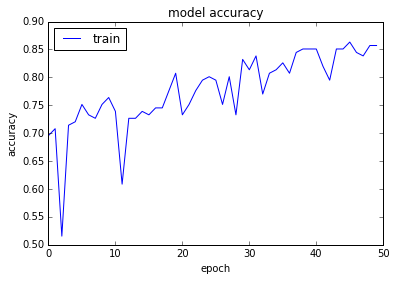

In [33]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
#plt.plot(mo)
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


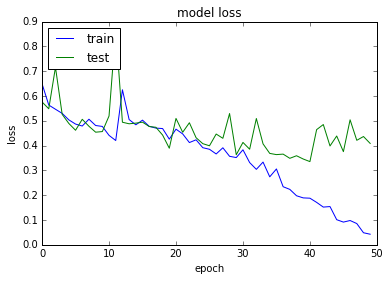

In [34]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [35]:
test_predictions = model.predict(test_images)

In [37]:
pred_df = test_df[['id']].copy()
pred_df['is_iceberg'] = test_predictions[:,1]
pred_df.to_csv('predictions.csv', index = False)
pred_df.sample(10)

,id,is_iceberg
7337,54156c1b,1.0
1729,1e053314,1.0
3587,88598e79,0.0
2818,576c6542,1.0
5962,f3433134,1.0
5411,807d6fa8,0.0
4117,963feedf,1.0
1791,7e9f355f,0.0
6734,8edd84ac,1.0
3096,5f483683,0.0
